# **Machine Learning for Factor Investing**

This notebook implements and expands on the ideas presented in [Coqueret and Guida (2021)](http://www.mlfactor.com/), please refer to their book as it provides a really good, data-oriented introduction to quantitative equity investing. My goal in this exercise is for nothing more than my own practice and learning, and all credit goes to the original authors.

I recommend running this notebook on [Google Colab](https://colab.research.google.com/), where you can up and running in only a few seconds. You might just need to download the [original data](https://github.com/shokru/mlfactor.github.io/blob/master/material/data_ml.RData) to your Google Drive.

### **Chapter 0.** Importing stuff and setup

In [1]:
# Basic stuff
import pandas as pd
import numpy as np
import datetime
from calendar import monthrange
from dateutil.relativedelta import relativedelta

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn")
plt.rcParams[
    "patch.facecolor"
] = "white"  # This is helpful if you're using Colab in dark mode
plt.rcParams["figure.figsize"] = 15, 7
# import graphviz

# Reading Rdata - need to install in Collab
# !pip install pyreadr
import pyreadr

# Regression type stuff
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import Lasso, Ridge, ElasticNet

from portfolio import *

# # Trees
# from sklearn import tree
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
# # from xgboost import XGBClassifier

# # Deep learning stuff
# import tensorflow as tf
# from tensorflow import keras

/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_5092/574601892.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### **Chapter 1.** Notations and data

Mostly ingesting the data and some quick and dirty data cleaning as well as initial exploration.

In [2]:
universe = pd.read_csv("../data/ibov_universe.csv", index_col=None)


universe = Portifolio(universe)
data = universe.pre_processing()
numeric_columns = universe.numeric_columns

/Users/zanchitta/Documents/ITA/PO-245/Fama-French-Factor-Models/src/portfolio.py:211: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  self.frame['data_da_analise'] = pd.to_datetime(self.frame['data_da_analise'])


In [3]:
# bigest returns:
data[["ticker", "ret12m"]].sort_values(by="ret12m", ascending=False).head(30)
data = data.drop(index=[1151, 963, 964, 990, 579, 883, 868, 274])
# data.loc[data['ticker'] == 'GGBR4',['date','ret12m','fator_cotacao','mkt_value','size','closed_price']]
# if fator_cotacao changes than display index:

[Text(0, 0, '2000'),
 Text(1, 0, '2001'),
 Text(2, 0, '2002'),
 Text(3, 0, '2003'),
 Text(4, 0, '2004'),
 Text(5, 0, '2005'),
 Text(6, 0, '2006'),
 Text(7, 0, '2007'),
 Text(8, 0, '2008'),
 Text(9, 0, '2009'),
 Text(10, 0, '2010'),
 Text(11, 0, '2011'),
 Text(12, 0, '2012'),
 Text(13, 0, '2013'),
 Text(14, 0, '2014'),
 Text(15, 0, '2015'),
 Text(16, 0, '2016'),
 Text(17, 0, '2017'),
 Text(18, 0, '2018'),
 Text(19, 0, '2019'),
 Text(20, 0, '2020'),
 Text(21, 0, '2021'),
 Text(22, 0, '2022')]

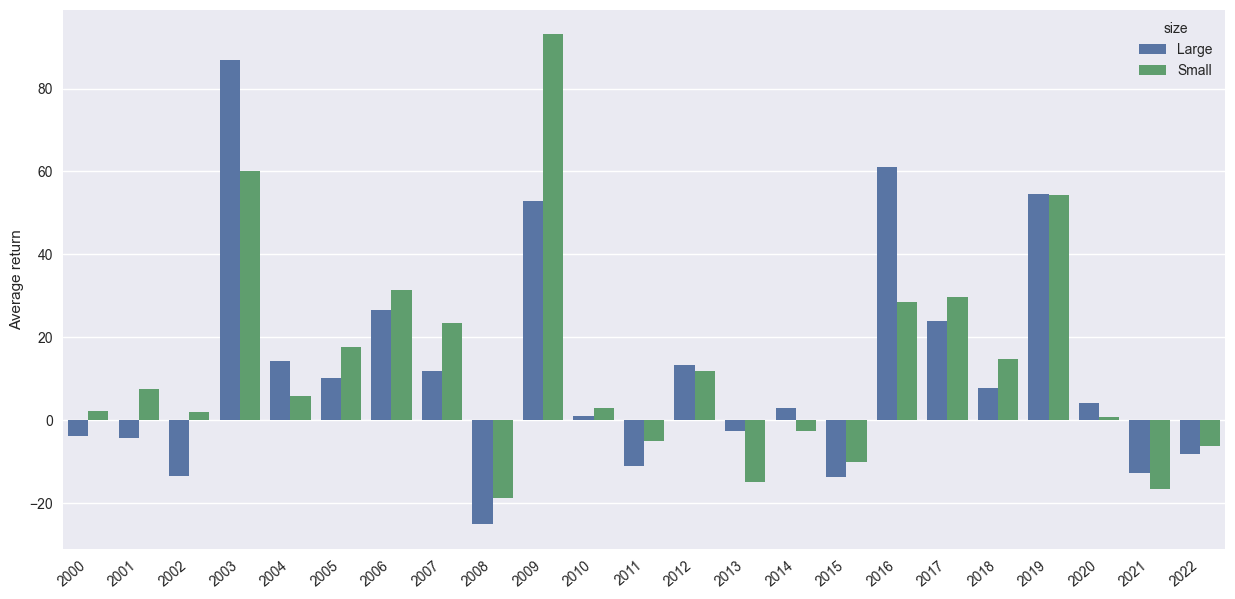

In [4]:
data["size"] = (
    data.groupby("date")["mkt_value"]
    .apply(lambda x: (x > x.median()))
    .reset_index(drop=True)
    .replace({True: "Large", False: "Small"})
)
data["year"] = data["date"].dt.year

return_by_size = data.groupby(["year", "size"])["ret12m"].mean().reset_index()

ax = sns.barplot(x="year", y="ret12m", hue="size", data=return_by_size)
ax.set(xlabel="", ylabel="Average return")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

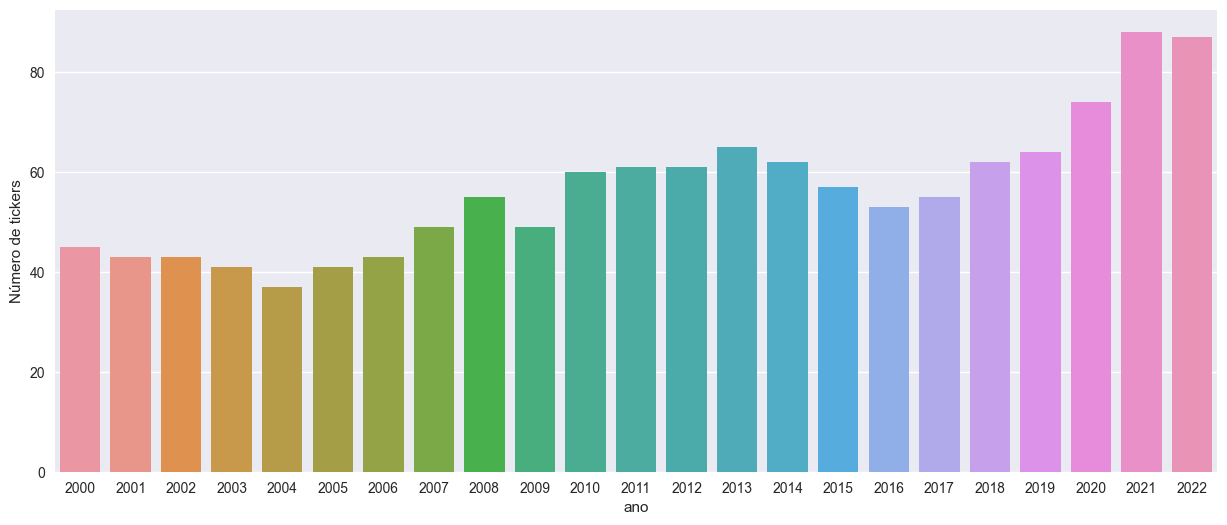

In [5]:
plt.figure(figsize=(15, 6))  # definindo o tamanho da figura
df = data.groupby(["year"])["ticker"].size().reset_index(name="count")

sns.barplot(data=df, x="year", y="count", width=0.8)
plt.xlabel("ano")
plt.ylabel("Número de tickers")
plt.show()

In [6]:
data.head()

,ticker,name,date,net_worth,qnt,ebit12m,closed_price,ativo_total,fator_cotacao,ret12m,...,ret1m,liq_corr,vol12m,vol6m,vol3m,vol1m,entreprise_value,mkt_value,size,year
0,ABEV3,AMBEV S/A,2022-12-29,8.643687e+10,1.575383e+10,18412913000,14.52,1.354667e+11,1,-0.875125,...,-3.988344,0.992880,24.551790,23.928674,24.563946,18.336817,2.126138e+11,2.286932e+11,Small,2022
1,ALPA4,ALPARGATAS,2022-12-29,5.512355e+09,6.830622e+08,23403000,15.08,8.127527e+09,1,-59.084942,...,-9.970149,2.496223,55.398722,61.196884,63.988089,59.822397,9.361016e+09,9.220934e+09,Large,2022
2,AMER3,AMERICANAS,2022-12-29,1.470556e+10,9.097745e+08,1165519000,9.65,4.708413e+10,1,-68.832343,...,-8.617424,2.240903,78.138246,90.704685,85.283618,72.447712,2.097531e+10,8.779324e+09,Large,2022
3,ARZZ3,AREZZO CO,2022-12-29,2.741961e+09,1.101861e+08,493801000,78.25,5.131922e+09,1,4.440704,...,-11.748876,1.692919,38.165783,39.791913,45.684485,44.448728,8.487425e+09,8.622061e+09,Large,2022
4,ASAI3,ASSAI,2022-12-29,3.980000e+09,1.350256e+09,2896000000,19.47,3.908900e+10,1,51.740298,...,-2.707196,0.807805,35.420312,35.197509,43.540761,34.983777,3.417704e+10,2.625204e+10,Large,2022


Visualização da quantidade de ativos por data, podemos verificar que o ibov cresceu em número de ações ordinárias ao longo do tempo.

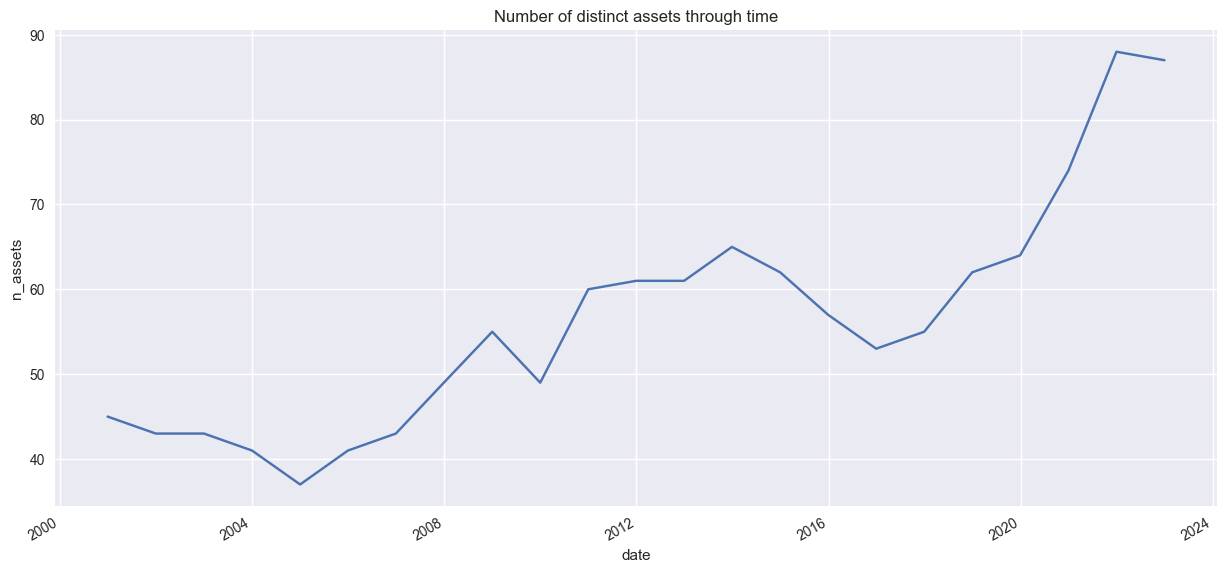

In [7]:
data.groupby("date")["ticker"].count().plot(
    ylabel="n_assets", title="Number of distinct assets through time"
);

Vamos normalizar as colunas numéricas:

In [8]:
numeric_columns

['net_worth',
 'qnt',
 'ret12m',
 'ret6m',
 'ret3m',
 'ret1m',
 'closed_price',
 'ebit12m',
 'fator_cotacao',
 'ativo_total',
 'vol12m',
 'vol6m',
 'vol3m',
 'vol1m',
 'mkt_value',
 'liq_corr',
 'entreprise_value']

In [9]:
# normalize numerical columns:
# import minmax scaler
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
transformer = scaler.fit(data[numeric_columns])
data[numeric_columns] = transformer.transform(data[numeric_columns])

# removendo elementos que estejam fora de 3 desvios padrões
data = data[(np.abs(data[numeric_columns]) < 3).all(axis=1)]

verificando normalização:

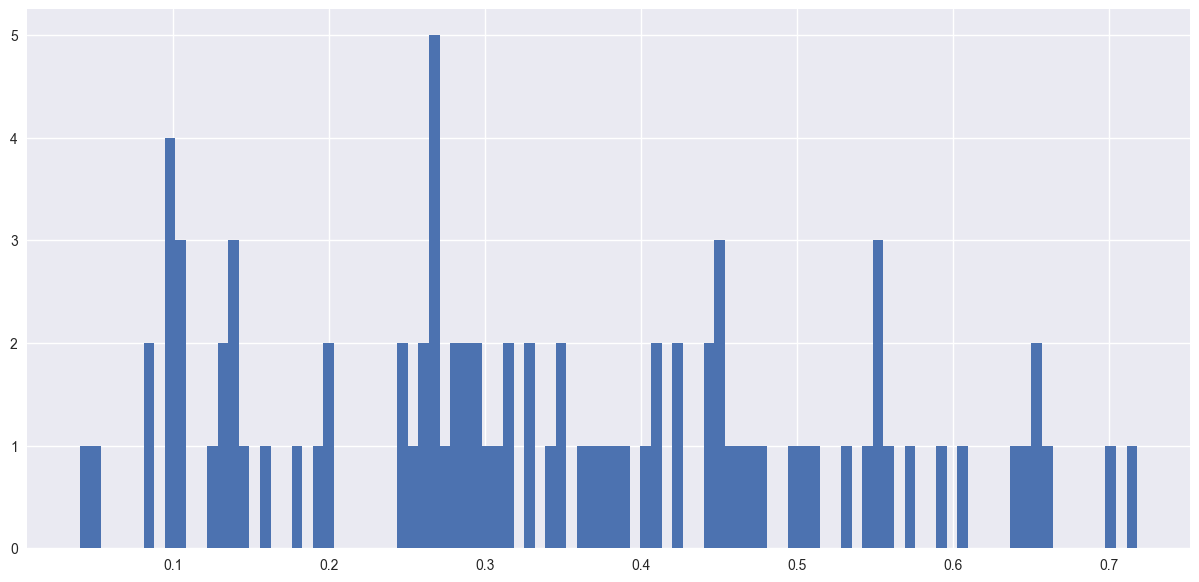

In [10]:
data.loc[(data["date"] == "2022-12-29"), "mkt_value"].hist(bins=100);

In [11]:
features = data.columns.to_list()[3:-7]
features_short = [
    "ebit12m",
    "ativo_total",
    "net_worth",
    "liq_corr",
    "vol12m",
    "mkt_value",
    "entreprise_value",
]

In [12]:
features

['net_worth',
 'qnt',
 'ebit12m',
 'closed_price',
 'ativo_total',
 'fator_cotacao',
 'ret12m',
 'ret6m',
 'ret3m',
 'ret1m',
 'liq_corr',
 'vol12m']

#### Separação de amostra de treino e teste

In [13]:
# find separation_date:
separation_date = data["date"].unique()[int(len(data["date"].unique()) * 0.8)]
print(f"separation_date: {separation_date}")

separation_date: 2004-12-30 00:00:00


In [14]:
separation_mask = data["date"] < separation_date

training_sample = data.loc[separation_mask]
testing_sample = data.loc[~separation_mask]

In [15]:
stock_ids = data["ticker"].unique().tolist()

max_dates = data.groupby("ticker")["date"].count().max()
stocks_with_max_dates = data.groupby("ticker")["date"].count() == max_dates
stock_ids_short = (
    stocks_with_max_dates.where(stocks_with_max_dates).dropna().index.tolist()
)  # these are stocks who have data for all timestamps

returns = data[data["ticker"].isin(stock_ids_short)][["date", "ticker", "ret1m"]]
returns = returns.pivot(index="date", columns="ticker");

## Factor Investing


Vamos agrupar os dados do nosso universo e realizar a segmentação das ações por tamanho, no

In [16]:
data["mkt_value"].describe()
# data.groupby('date')['VM'].apply(lambda x: (x > x.median()))

count    1295.000000
mean        0.277948
std         0.199385
min         0.000000
25%         0.107430
50%         0.254238
75%         0.421347
max         0.737978
Name: mkt_value, dtype: float64

[Text(0, 0, '2000'),
 Text(1, 0, '2001'),
 Text(2, 0, '2002'),
 Text(3, 0, '2003'),
 Text(4, 0, '2004'),
 Text(5, 0, '2005'),
 Text(6, 0, '2006'),
 Text(7, 0, '2007'),
 Text(8, 0, '2008'),
 Text(9, 0, '2009'),
 Text(10, 0, '2010'),
 Text(11, 0, '2011'),
 Text(12, 0, '2012'),
 Text(13, 0, '2013'),
 Text(14, 0, '2014'),
 Text(15, 0, '2015'),
 Text(16, 0, '2016'),
 Text(17, 0, '2017'),
 Text(18, 0, '2018'),
 Text(19, 0, '2019'),
 Text(20, 0, '2020'),
 Text(21, 0, '2021'),
 Text(22, 0, '2022')]

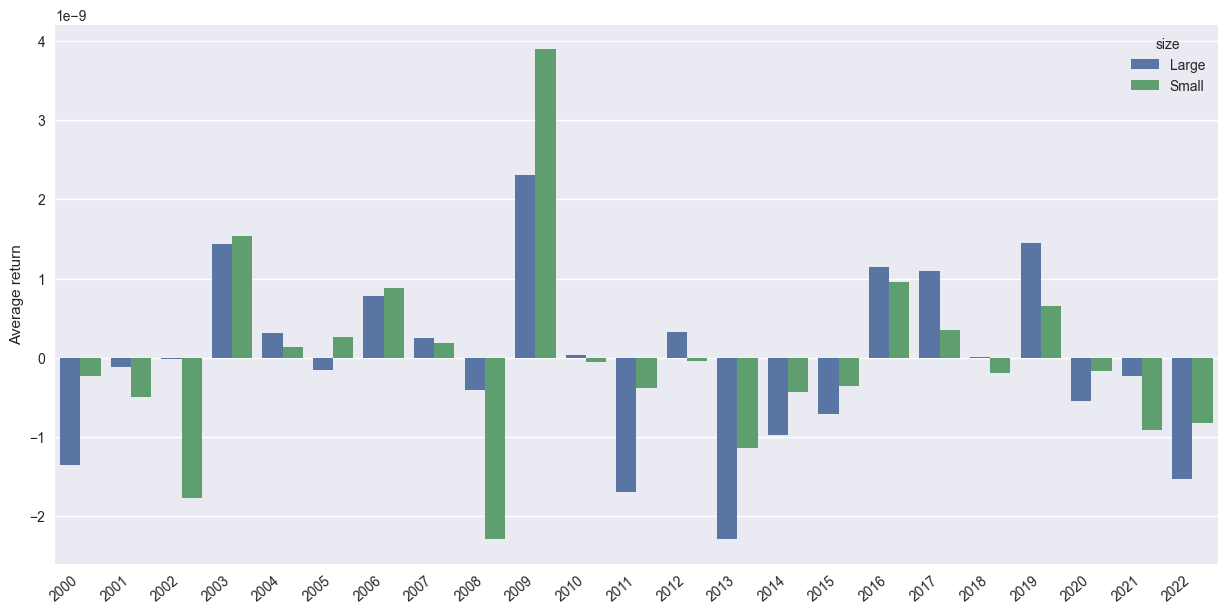

In [17]:
data["size"] = (
    data.groupby("date")["mkt_value"]
    .apply(lambda x: (x > x.median()))
    .reset_index(drop=True)
    .replace({True: "Large", False: "Small"})
)
data["year"] = data["date"].dt.year

return_by_size = data.groupby(["year", "size"])["ret12m"].mean().reset_index()

ax = sns.barplot(x="year", y="ret12m", hue="size", data=return_by_size)
ax.set(xlabel="", ylabel="Average return")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [18]:
data[["ticker", "ret12m", "date"]].sort_values(by="ret12m", ascending=False).head(10)

,ticker,ret12m,date
889,RSID3,6.523842e-08,2009-12-30
872,GFSA3,2.196523e-08,2009-12-30
298,QUAL3,1.564633e-08,2019-12-27
436,BRAP4,1.558673e-08,2016-12-28
1132,ACES4,1.130674e-08,2003-12-30
1227,CRUZ3,1.106119e-08,2001-12-28
1009,ACES4,1.047374e-08,2006-12-28
1136,BRAP4,1.046408e-08,2003-12-30
727,VAGR3,8.573055e-09,2012-12-28
956,VIVO4,7.806404e-09,2008-12-30


In [19]:
# lendo os fatores:
ff_factors = pd.read_csv("../data/risk_factors/factors.csv", index_col=None)
# ajustando os tipos das colunas:
ff_factors["date"] = pd.to_datetime(ff_factors["date"])
# ff_factors['date'] = ff_factors['date'].dt.strftime("%Y/%m/%d")
ff_factors.rename({"Risk_free": "RF", "Rm_minus_Rf": "MKT_RF"}, axis=1, inplace=True)
columns_to_float = ff_factors.columns[1:]
ff_factors[columns_to_float] = ff_factors[columns_to_float].astype(float)
display(ff_factors.head())

,date,MKT_RF,HML,IML,SMB,WML,RF
0,2001-01-02,0.006601,0.065490,0.014109,0.000524,-0.006308,0.000579
1,2001-01-03,0.062427,0.009390,0.004510,0.005390,-0.028644,0.000577
2,2001-01-04,-0.000310,-0.002327,-0.009227,0.006690,-0.000946,0.000574
3,2001-01-05,-0.012839,-0.002397,0.025124,0.003523,0.005985,0.000573
4,2001-01-08,0.003982,0.001948,-0.001175,0.007883,-0.004099,0.000573


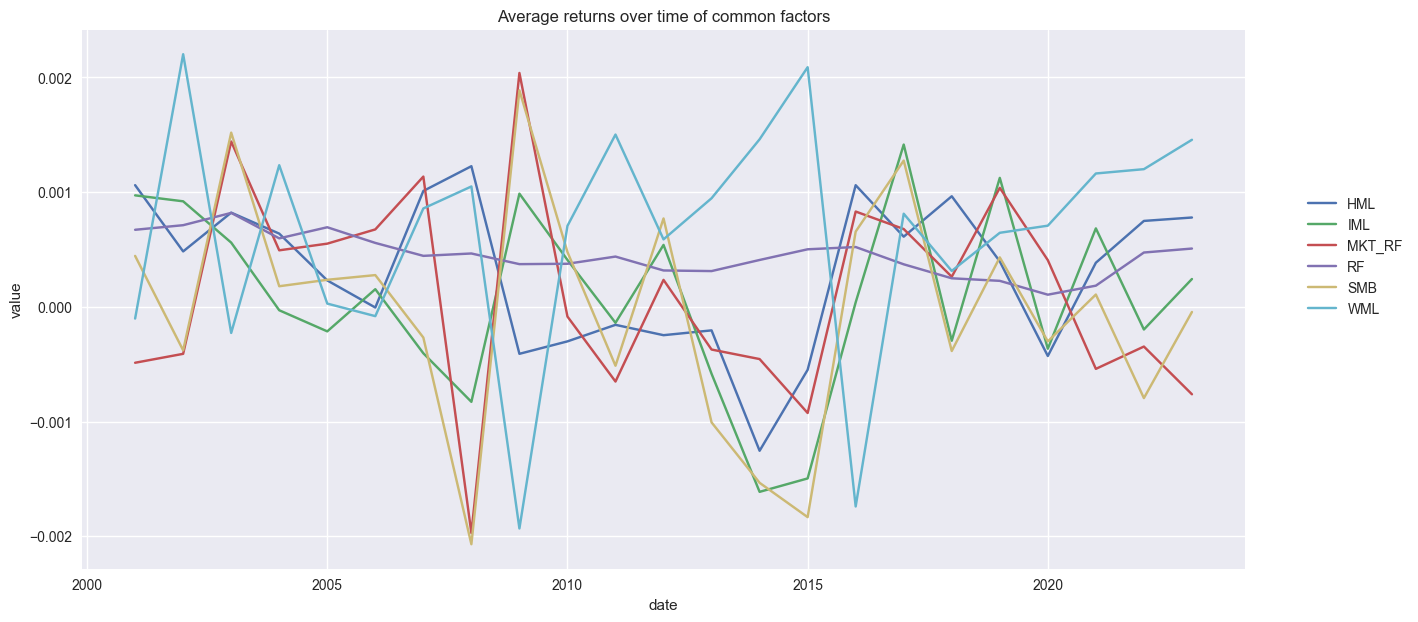

In [20]:
temp_factors = ff_factors.copy()

temp_factors["date"] = temp_factors["date"].dt.year
temp_factors = pd.melt(temp_factors, id_vars="date")
temp_factors = temp_factors.groupby(["date", "variable"]).mean().reset_index()

plt = sns.lineplot(x="date", y="value", hue="variable", data=temp_factors)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.0)
plt.set_title("Average returns over time of common factors");
# replicating this from the book for completeness only, but i think it's a pretty messy chart
# it's hard to take much insight from it

<Axes: title={'center': 'Cumulative factor performance since January 2001'}>

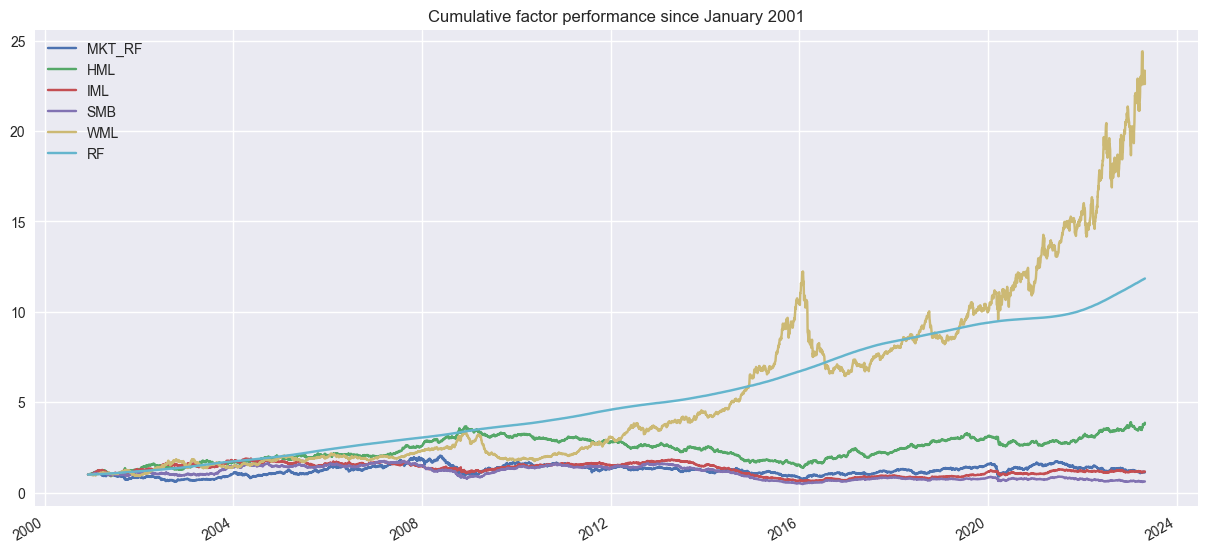

In [21]:
# let's see how factors cumulative performance over time
# but wrap that in a function that allows you to choose the start period (as that influences cumulative performance a lot)


def plot_cumulative_performance(df, start_date=None):
    # this function will plot cumulative performance for any wide dataframe of returns (e.g. index is date, columns are assets/factor)
    # optional: you can pass the start date in %m/%d/%y format e.g. '1/1/1995', '12/15/2000'
    # if you don't pass a start date, it will use the whole sample

    cumul_returns = (1 + df.set_index("date")).cumprod()

    if start_date is None:
        start_date = cumul_returns.index.min()
    else:
        start_date = datetime.strptime(start_date, "%m/%d/%Y")
        cumul_returns = cumul_returns.loc[cumul_returns.index >= start_date]

    first_line = pd.DataFrame(
        [[1.0 for col in cumul_returns.columns]],
        columns=cumul_returns.columns,
        index=[start_date - relativedelta(months=1)],
    )

    cumul_returns = pd.concat([first_line, cumul_returns])

    return cumul_returns.plot(
        title=f'Cumulative factor performance since {start_date.strftime("%B %Y")}'
    )


plot_cumulative_performance(ff_factors)

Below we perform **Fama-Macbeth regressions**, which is the standard way of validating a factor's risk premium in the cross-section of stock returns. As we will see, this involves a two-step process of:

*   Time-series regression: regress each asset's returns on factors, i.e. one regression per asset. Store the coefficients.
*   Cross-section regression: regress each asset's returns on coefficients obtained in previous step, i.e. one regression per time period.


In [22]:
# merging and cleaning up the data before we run the regressions
data_fm = data[["date", "ticker", "ret1m"]][data["ticker"].isin(stock_ids_short)]
data_fm = data_fm.merge(ff_factors, on="date")
data_fm["ret1m"] = data_fm.groupby("ticker")["ret1m"].shift(1)
data_fm.dropna(inplace=True)

# running time series regressions

reg_output = {}

for k, g in data_fm.groupby("ticker"):
    model = ols("ret1m ~ MKT_RF + SMB + HML + WML + IML", data=g)
    results = model.fit()

    reg_output[k] = results.params

betas = pd.DataFrame.from_dict(reg_output).T
betas.head()

,Intercept,MKT_RF,SMB,HML,WML,IML
BBAS3,2.984889e-13,-3.689061e-11,2.722655e-10,6.970796e-11,6.099663e-11,-2.705771e-10
BBDC4,9.106803e-13,7.366769e-11,-7.278835e-11,-3.734883e-12,1.575154e-10,-1.049674e-11
BRAP4,3.348301e-10,8.569816e-09,-3.556661e-08,4.776864e-08,4.395098e-08,-5.269203e-09
CMIG4,6.176679e-11,-3.400345e-10,-6.426513e-09,3.907505e-09,1.725440e-10,-5.409598e-10
CSNA3,4.777403e-11,-2.327707e-09,4.008798e-09,5.657986e-09,5.235228e-09,-3.546903e-09


In [23]:
betas.describe()

,Intercept,MKT_RF,SMB,HML,WML,IML
count,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01
mean,6.523370e-11,9.096165e-10,-3.149757e-09,7.644383e-09,5.546588e-09,-2.786393e-09
std,1.025180e-10,3.880471e-09,1.191595e-08,1.451219e-08,1.358229e-08,3.532395e-09
min,-3.175058e-13,-3.634236e-09,-3.556661e-08,-3.734883e-12,6.099663e-11,-1.147093e-08
25%,8.120137e-13,-3.352970e-10,-1.765161e-09,2.385359e-10,2.809927e-10,-3.435361e-09
50%,3.050781e-11,-1.488476e-10,2.645044e-10,3.133418e-09,7.729236e-10,-1.651832e-09
75%,8.194790e-11,1.718013e-10,7.469711e-10,5.612291e-09,2.047052e-09,-4.280088e-10
max,3.348301e-10,8.569816e-09,6.940836e-09,4.776864e-08,4.395098e-08,-1.049674e-11


In [24]:
# prepping coeficient data to run second round of regressions
loadings = betas.drop("Intercept", axis=1).reset_index(drop=True)
ret = returns.T.reset_index(drop=True)
fm_data = pd.concat([loadings, ret], axis=1)
fm_data = pd.melt(fm_data, id_vars=["MKT_RF", "SMB", "HML", "WML", "IML"])

# running cross section regressions

reg_output_2 = {}

for k, g in fm_data.groupby("variable"):
    model = ols("value ~ MKT_RF + SMB + HML + WML + IML", data=g)
    results = model.fit()

    reg_output_2[k] = results.params

# refer to the mlfactor book or the fama-macbeth literature for more info on what the gammas stand for
# but you can think of them as an estimate of a given factor's risk premium at a point in time
gammas = (
    pd.DataFrame.from_dict(reg_output_2)
    .T.reset_index()
    .rename({"index": "date"}, axis=1)
)
gammas.head()

,date,Intercept,MKT_RF,SMB,HML,WML,IML
0,2000-12-27,-8.221775e-13,-0.017082,-0.033396,-0.019110,0.036686,-0.039945
1,2001-12-28,2.368666e-11,-0.014371,-0.013935,0.012224,-0.007600,0.006195
2,2002-12-30,7.432160e-12,-0.022565,-0.021699,0.014824,-0.002302,-0.007604
3,2003-12-30,4.877728e-13,0.027749,-0.027782,0.026260,0.029744,-0.012482
4,2004-12-30,6.494738e-12,0.029043,-0.007134,-0.000175,-0.002229,-0.025474


In [25]:
fm_data.head()

,MKT_RF,SMB,HML,WML,IML,variable,value
0,-3.689061e-11,2.722655e-10,6.970796e-11,6.099663e-11,-2.705771e-10,2000-12-27,2.137692e-12
1,7.366769e-11,-7.278835e-11,-3.734883e-12,1.575154e-10,-1.049674e-11,2000-12-27,-6.673642e-13
2,8.569816e-09,-3.556661e-08,4.776864e-08,4.395098e-08,-5.269203e-09,2000-12-27,1.947236e-09
3,-3.400345e-10,-6.426513e-09,3.907505e-09,1.725440e-10,-5.409598e-10,2000-12-27,1.880327e-10
4,-2.327707e-09,4.008798e-09,5.657986e-09,5.235228e-09,-3.546903e-09,2000-12-27,1.637850e-10


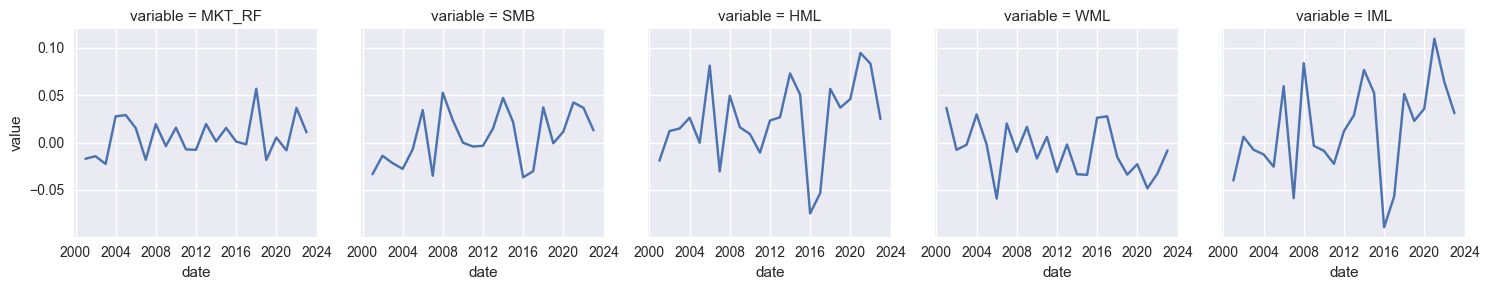

In [26]:
# since we get one estimate of that risk premium for each time step, we can plot how it evolves over time
x = pd.melt(gammas.drop("Intercept", axis=1), id_vars="date")

g = sns.FacetGrid(x, col="variable")
g.map(sns.lineplot, "date", "value")

Below we deploy the factor competition strategy outlined in the book. The main idea here is to regress a factor on the remaining factors and test whether the coefficient is significant. A significant coefficient means that the factors on the right-hand side don't completely explain the factor on the left-hand side, which naturally means the latter is useful.


In [27]:
factor_comp = pd.melt(ff_factors.drop("RF", axis=1), id_vars="date")

factor_comp = factor_comp.merge(ff_factors.drop("RF", axis=1), on="date")

factor_comp_coefs = {}
factor_comp_tstats = {}

for k, g in factor_comp.groupby("variable"):
    reg_data = g.drop([k, "date", "variable"], axis=1)
    formula = "value ~ " + " + ".join(reg_data.columns.values[1:].tolist())

    model = ols(formula, data=reg_data)
    results = model.fit()

    factor_comp_coefs[k] = results.params
    factor_comp_tstats[k] = results.tvalues

alphas = pd.DataFrame.from_dict(factor_comp_coefs).T
alphas_tstats = pd.DataFrame.from_dict(factor_comp_tstats).T

alphas_tstats

,HML,IML,Intercept,MKT_RF,SMB,WML
HML,NaN,5.755685,2.453682,14.145168,6.182620,-2.503500
IML,5.755685,NaN,1.226122,-32.784479,86.952400,4.493869
MKT_RF,14.145168,-32.784479,1.237863,NaN,14.168563,-6.969435
SMB,6.182620,86.952400,-0.478255,14.168563,NaN,-19.110036
WML,-2.503500,4.493869,4.515045,-6.969435,-19.110036,NaN


In [28]:
alphas_table = alphas.round(3).applymap(str)

prob99 = 2.58
prob95 = 1.96

alphas_table[alphas_tstats >= prob99] = alphas_table[alphas_tstats >= prob99] + " (**)"
alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] = (
    alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] + " (*)"
)

factors = factor_comp.columns[3:].tolist()

alphas_table = alphas_table[["Intercept"] + factors].reindex(factors)

alphas_table

,Intercept,MKT_RF,HML,IML,SMB,WML
MKT_RF,0.0,nan,0.306 (**),-0.99,0.447 (**),-0.127
HML,0.0 (*),0.114 (**),nan,0.116 (**),0.121 (**),-0.028
IML,0.0,-0.165,0.051 (**),nan,0.739 (**),0.033 (**)
SMB,-0.0,0.079 (**),0.057 (**),0.782 (**),nan,-0.142
WML,0.001 (**),-0.069,-0.04,0.109 (**),-0.437,nan


Below we explore factor time series momentum by looking at the partial auto-correlation functions. The shaded lines are confidence intervals, which the *statsmodels* library handily calculates for us by default (at 5% confidence levels).


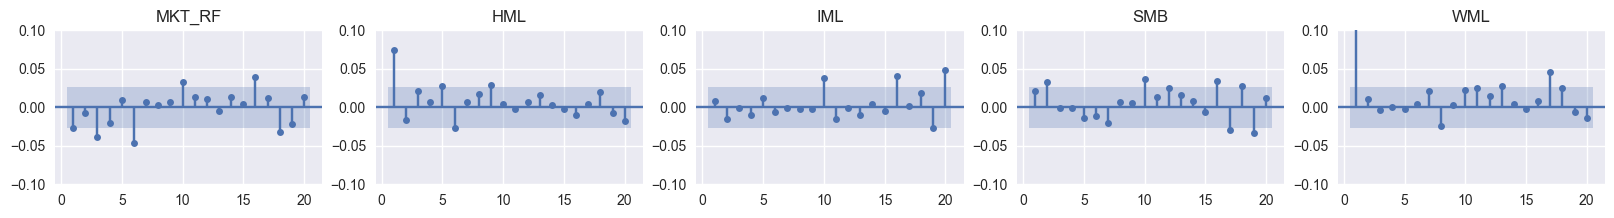

In [29]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

nfactors = len(factors)

# Plot y from -0.1 to 0.1:
fig, axs = plt.subplots(ncols=nfactors, figsize=(20, 2))

for i, factor in enumerate(factors):
    plot_pacf(ff_factors[factor], ax=axs[i], lags=20, zero=False, title=factor)
    axs[i].set_ylim(-0.1, 0.1)

plt.show()